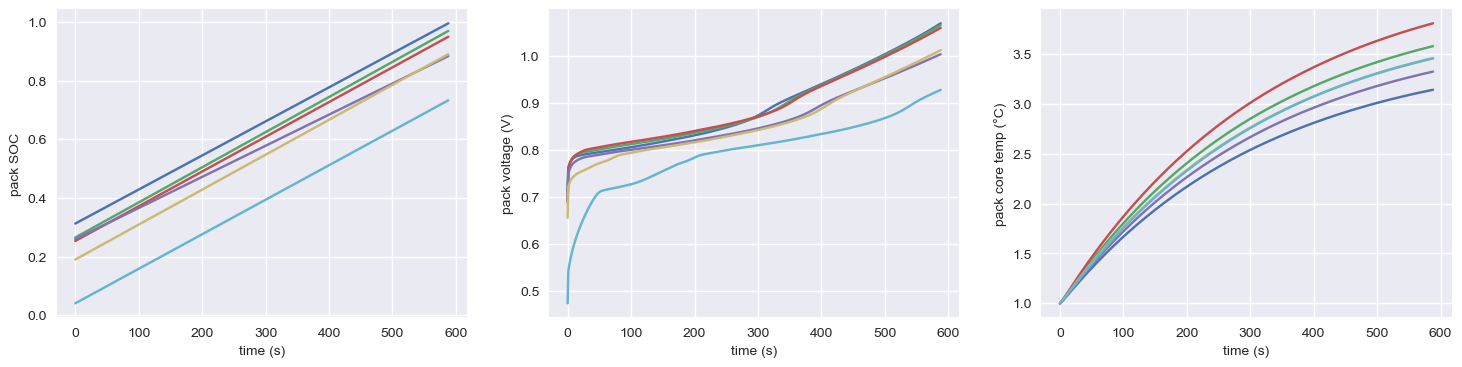

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from LIBEnv.LIB_gym_delta import LIBPackEnv
plt.style.use('seaborn-v0_8') # seaborn-v0_8

env = LIBPackEnv('./LIBEnv/PANmodel.mat', number_of_cells=6, T=25, dt=1)

pack_res=[]
rewards = []
pack_res.append(env.reset()[0].reshape(3,6))
done = False
while not done:
    next_state, reward, done, _, info = env.step(np.ones(7))
    pack_res.append(next_state.reshape(3,6))
    rewards.append(reward)

pack_res = np.array(pack_res)
plt.figure(figsize=(18,4))
plt.subplot(1,3,1)
plt.plot(pack_res[:,0,:])
plt.xlabel('time (s)')
plt.ylabel('pack SOC')
plt.grid('on')
plt.subplot(1,3,2)
plt.plot(pack_res[:,1,:])
plt.xlabel('time (s)')
plt.ylabel('pack voltage (V)')
plt.grid('on')
plt.subplot(1,3,3)
plt.plot(pack_res[:,2,:])
plt.xlabel('time (s)')
plt.ylabel('pack core temp (°C)')
plt.grid('on')

# CC/CV without balancing

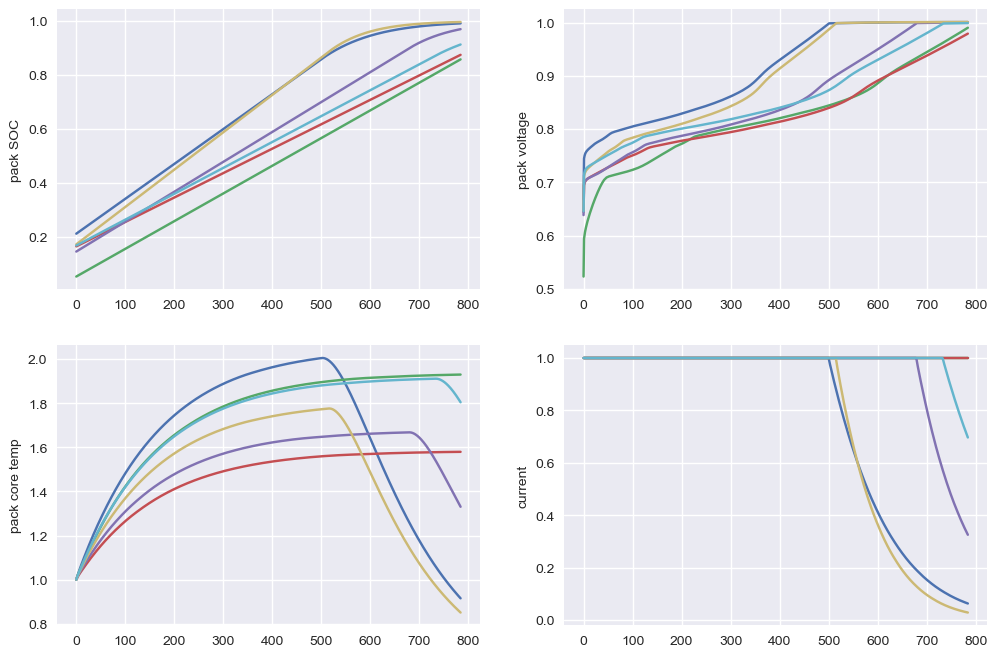

In [2]:
from copy import copy

env = LIBPackEnv('./LIBEnv/PANmodel.mat', number_of_cells=6, T=25, dt=1)


CC = 100
Rbal = 10000
env.overcharge_voltage = 4.1

state, _ = env.reset()

pack_res = []
rewards = []
actions = []

done = False
pack_res.append(state.reshape(3,6))
while not done:
    copy_env = copy(env)
    v = copy_env.step(np.zeros(7))[0][6:12] * (env.max_voltage-env.min_voltage) + env.min_voltage # fixed voltage
    ik = (v - env.overcharge_voltage)/env.pack.ECM.R0Param; # compute test ik to achieve maxV
    ik = np.clip(-CC,ik,0); # but limit ik to no more than CC in mag.
    action = np.hstack([ik.ravel()/env.current_ratio,1])
    next_state, reward, done, _, info = env.step(action)
    state = next_state

    pack_res.append(next_state.reshape(3,6))
    rewards.append(reward)
    actions.append(action)

pack_res = np.array(pack_res)
plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
plt.plot(pack_res[:-1,0,:])
plt.ylabel('pack SOC')
plt.grid('on')
plt.subplot(2,2,2)
plt.plot(pack_res[:-1,1,:])
plt.ylabel('pack voltage')
plt.grid('on')
plt.subplot(2,2,3)
plt.plot(pack_res[:-1,2,:])
plt.ylabel('pack core temp')
plt.grid('on')
plt.subplot(2,2,4)
plt.plot(np.array(actions)[:,:-1].reshape(-1,6))
plt.ylabel('current')
plt.grid('on')


# CC/CV with balancing

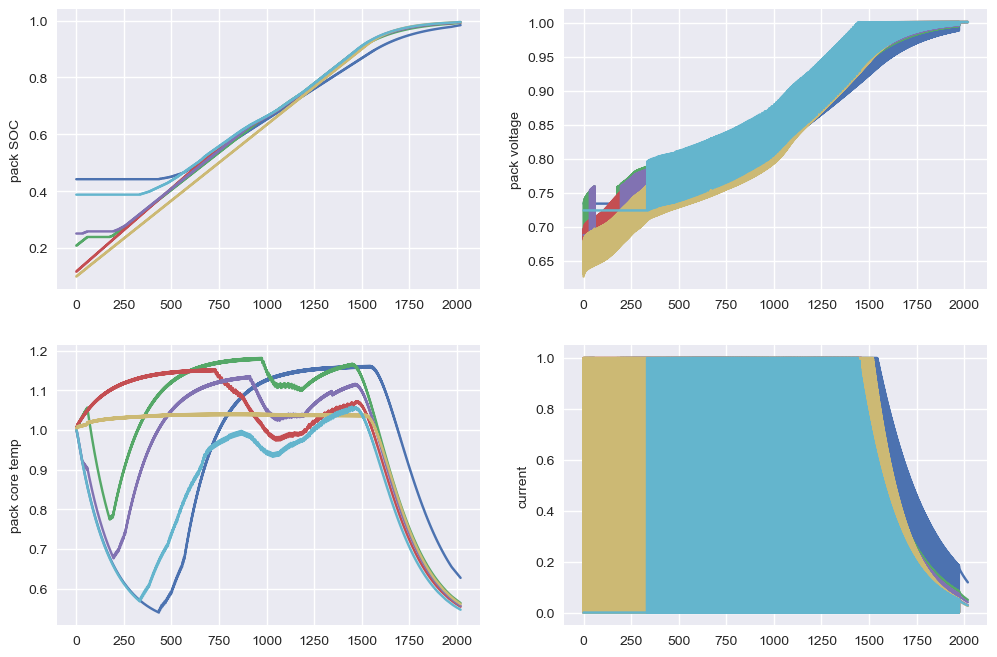

In [10]:
from copy import copy

env = LIBPackEnv('./LIBEnv/PANmodel.mat', number_of_cells=6, T=25, dt=1)


CC = 100
Rbal = 1e-3
env.overcharge_voltage = 4.1

state, _ = env.reset()

pack_res = []
rewards = []
actions = []

done = False
pack_res.append(state.reshape(3,6))
while not done:
    # CC/CV
    copy_env = copy(env)
    v = copy_env.step(np.zeros(7))[0][6:12] * (env.max_voltage-env.min_voltage) + env.min_voltage # fixed voltage
    i_charge = (v - env.overcharge_voltage)/env.pack.ECM.R0Param; # compute test ik to achieve maxV
    ik = np.clip(-CC,ik,0); # but limit ik to no more than CC in mag.
    # action = np.hstack([ik.ravel()/env.current_ratio,1])
    # next_state, reward, done, _, info = env.step(action)
    # state = next_state
    
    # passive balancing
    cell_voltages = state[6:12]*(env.max_voltage-env.min_voltage) + env.min_voltage
    checkBalance = ((cell_voltages - cell_voltages.min()) - 1e-2 >= 0)
    v_balance = cell_voltages*checkBalance 
    # Set non-balance cell voltage to 0 for calculation (to ensure balance current = 0 for no-balance cells)
    i_balance = (v_balance/Rbal)   # Current calculated for balance cell, with parallel resistor 
    i_balance = np.clip(0,i_balance,CC)

    ik = i_charge+i_balance
    ik = np.clip(-CC,ik,CC)
    action = np.hstack([ik.ravel()/env.current_ratio,1])

    next_state, reward, done, _, info = env.step(action)
    state = next_state

    
    pack_res.append(next_state.reshape(3,6))
    rewards.append(reward)
    actions.append(action)

pack_res = np.array(pack_res)
plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
plt.plot(pack_res[:-1,0,:])
plt.ylabel('pack SOC')
plt.grid('on')
plt.subplot(2,2,2)
plt.plot(pack_res[:-1,1,:])
plt.ylabel('pack voltage')
plt.grid('on')
plt.subplot(2,2,3)
plt.plot(pack_res[:-1,2,:])
plt.ylabel('pack core temp')
plt.grid('on')
plt.subplot(2,2,4)
plt.plot(np.array(actions)[:,:-1].reshape(-1,6))
plt.ylabel('current')
plt.grid('on')


In [7]:
cell_voltages

array([4.099906 , 3.9698205, 3.085497 , 4.0999546, 4.099774 , 4.099406 ],
      dtype=float32)

In [9]:
((cell_voltages - cell_voltages.min()) - 1e-2 >= 0)

array([ True,  True, False,  True,  True,  True])

In [ ]:
checkBalance = ((cell_voltages - cell_voltages.min()) - 1e-2 >= 0)


(0.0, 50.0)

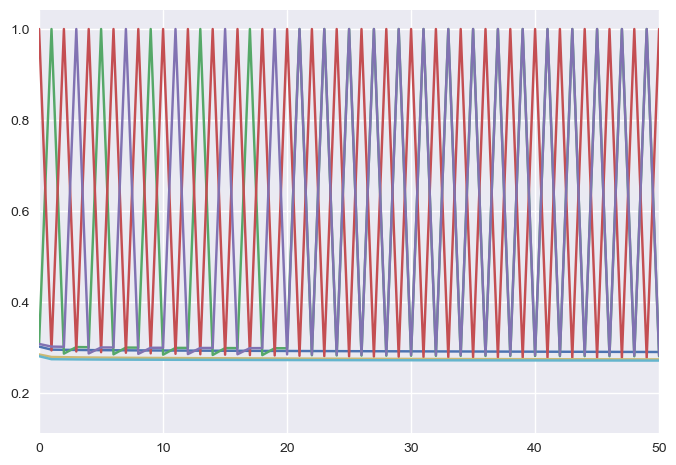

In [83]:
plt.plot(np.array(actions)[:,:-1].reshape(-1,6))
plt.xlim([0,50])

In [84]:
np.array(actions)[:,:-1].reshape(-1,6)

array([[0.30164688, 0.30863045, 1.        , 0.3074398 , 0.2842643 ,
        0.2803994 ],
       [0.29484787, 1.        , 0.29313232, 0.30155304, 0.27878075,
        0.27381744],
       [0.29451637, 0.28613304, 1.        , 0.30118149, 0.27832893,
        0.2736145 ],
       ...,
       [0.15602158, 0.15732803, 0.1751828 , 1.        , 1.        ,
        1.        ],
       [0.17496628, 0.17502769, 1.        , 0.15878983, 0.15862915,
        0.15493813],
       [0.17488083, 1.        , 0.15327667, 0.17458099, 0.17419426,
        1.        ]])